In [6]:
import triflow as trf
import numpy as np
import pylab as pl
import scipy.signal

%matplotlib inline

In [2]:
# I stole this. It's pretty: shaded elevation plots. Nice.
# http://geoexamples.blogspot.fr/2014/03/shaded-relief-images-using-gdal-python.html
# I only use the hillshade, because lazy and stuff.

def hillshade(array, azimuth, angle_altitude):
        
    x, y = np.gradient(array)
    slope = np.pi/2. - np.arctan(np.sqrt(x*x + y*y))
    aspect = np.arctan2(-x, y)
    azimuthrad = azimuth*np.pi / 180.
    altituderad = angle_altitude*np.pi / 180.
     
 
    shaded = np.sin(altituderad) * np.sin(slope)\
     + np.cos(altituderad) * np.cos(slope)\
     * np.cos(azimuthrad - aspect)
    return 255*(shaded + 1)/2

Triflow is not able to handle 2D simution by itself. We have to help and provide our own routine.
It will be slower than Triflow compiler, but enough for our computation.
We have to provide:

- The derivative F
- A template for the fields (which describe their dimension and coordinates)
- The Jacobian for implicits schemes. Lazy me, we will drop the jacobian for now.

In [3]:
class NonConservative_ShallowWater:
    @staticmethod
    def F(fields, pars):
        Ffields = fields.copy()
        x = fields["x"].values
        h = fields["h"].values
        u = fields["u"].values
        v = fields["v"].values
        H = fields["H"].values

        delta_x = x.ptp() / (x.size - 1)
        delta_y = y.ptp() / (y.size - 1)

        def dx(U):
            return (np.roll(U, -1, axis=0) - np.roll(U, 1, axis=0)) / (2 * delta_x)
        def dy(U):
            return (np.roll(U, -1, axis=1) - np.roll(U, 1, axis=1)) / (2 * delta_y)
        
        def dxx(U):
            return (np.roll(U, 1, axis=0) - 2 * U + np.roll(U, -1, axis=0)) / (delta_x**2)
        def dyy(U):
            return (np.roll(U, 1, axis=1) - 2 * U + np.roll(U, -1, axis=1)) / (delta_y**2)

        eta = h + H
        visc = lambda var: pars["nu"] * (dxx(var) + dyy(var))
        dth = -(dx(u * eta) + dy(v * eta))
        dtu = -(u * dx(u) + v * dy(u)) + pars["f"] * v - 9.81 * dx(h) + visc(u)
        dtv = -(u * dx(v) + v * dy(v)) - pars["f"] * u - 9.81 * dy(h) + visc(v)

        Ffields["h"][:] = dth
        Ffields["u"][:] = dtu
        Ffields["v"][:] = dtv
        return Ffields.uflat
    _indep_vars = ["x", "y"]
    fields_template = trf.core.fields.BaseFields.factory(("x", "y"),
                                                         [("h", ("x", "y")),
                                                          ("u", ("x", "y")),
                                                          ("v", ("x", "y"))],
                                                         [("H", ("x", "y"))])

In [4]:
model = NonConservative_ShallowWater()

In [7]:
Nx = Ny = 350
x = np.linspace(0, 5, Nx)
y = np.linspace(0, 5, Ny)
u = np.zeros((Nx, Ny)) + 2
v = np.zeros((Nx, Ny)) + 2
h = np.zeros((Nx, Ny)) + (scipy.signal.gaussian(Nx, 5) * scipy.signal.gaussian(Ny, 5)[:, None]) * 1  # It's like a drop. Or close enough
H = np.ones((Nx, Ny)) * 10

Wooow, a drop


/home/nicolas/.cache/pypoetry/virtualenvs/triflow-py3.6/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


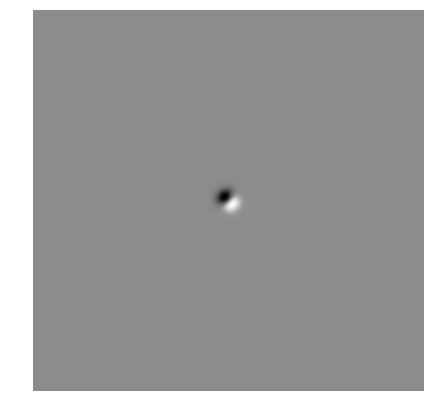

In [14]:
pl.figure(figsize=(7, 7))
pl.contourf(hillshade(h + H, 45, 50), 200, cmap='Greys')
pl.grid(False)
pl.axis('off')
print("Wooow, a drop")

In [15]:
init_fields = model.fields_template(x=x, y=y, h=h, u=u, v=v, H=H)
pars = {"f": 0, "nu": 1E-6}  # no coriolis effect, water viscosity

In [26]:
# I'm a lazy shit, I don't want to provide the jacobian. Lucky me, scipy ode do not need it. (explicit schemes)

simul = trf.Simulation(model, init_fields.copy(), pars, dt=.01, tmax=.4,
                       scheme=trf.schemes.scipy_ode, interpolator="dopri5",
                       id="wave_animation")
simul.attach_container(None)  # some test, this directory will exist. force=True over-write.


path:   None
None

In [27]:
for t, fields in simul:
    print(f"t: {t:g}".ljust(10), end="\r")

/home/nicolas/Documents/03-projets/01-python/01-repositories/triflow/triflow/core/schemes.py:46: RuntimeWarning: divide by zero encountered in double_scalars
  dt_ = np.sqrt(dt ** 2 * tol / err)


/home/nicolas/Documents/03-projets/01-python/01-repositories/triflow/triflow/plugins/container.py:130: FutureWarning: casting an xarray.Dataset to a boolean will change in xarray v0.11 to only include data variables, not coordinates. Cast the Dataset.variables property instead to preserve existing behavior in a forwards compatible manner.
  if concatenated_fields and self.path:


In [35]:
container = simul.container
eta = container.data["h"] + container.data["H"]
norm_eta = ((eta - eta.min())  / (eta.max() - eta.min()))

interp_on_time = scipy.interpolate.interp1d(container.data["t"], norm_eta, axis=0)

(0.0, 5.0, 0.0, 5.0)

/home/nicolas/.cache/pypoetry/virtualenvs/triflow-py3.6/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


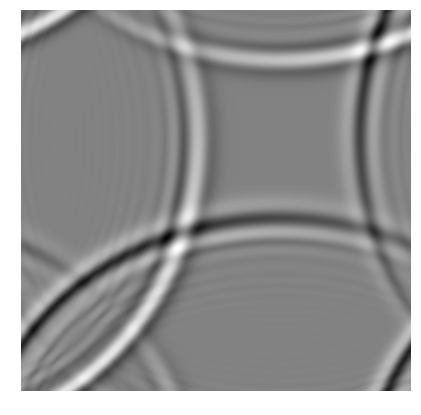

In [40]:
pl.figure(figsize=(7, 7))
pl.contourf(x, y, hillshade(interp_on_time(t), 45, 20), 200, cmap="gray")
pl.grid(False)
pl.axis('off')

/home/nicolas/.cache/pypoetry/virtualenvs/triflow-py3.6/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


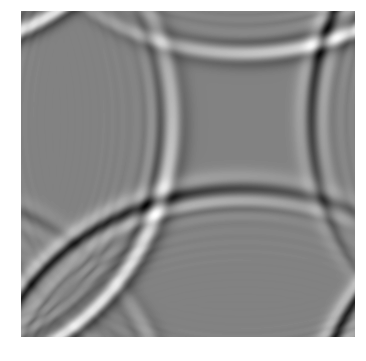

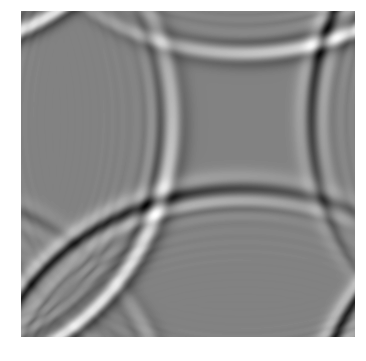

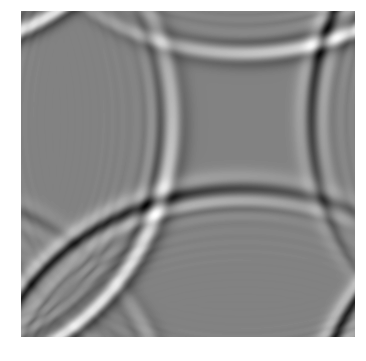

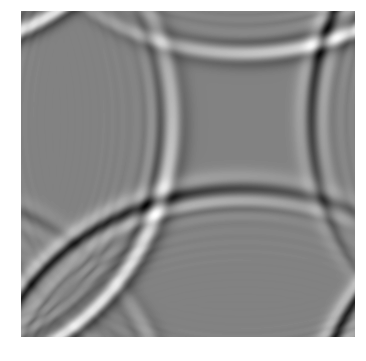

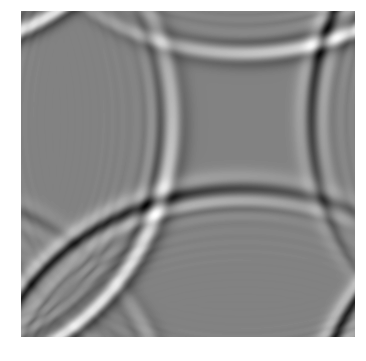

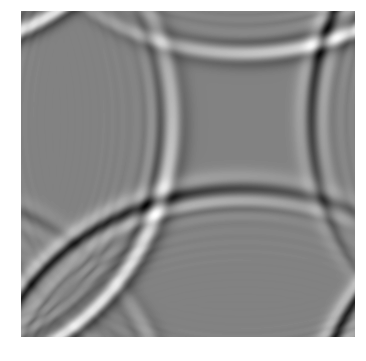

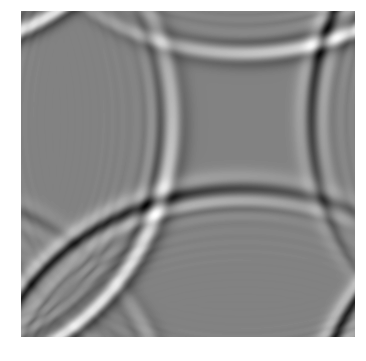

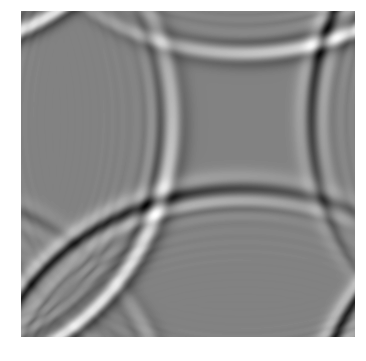

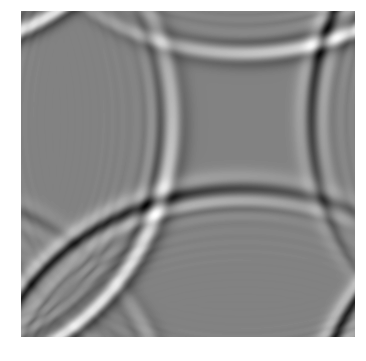

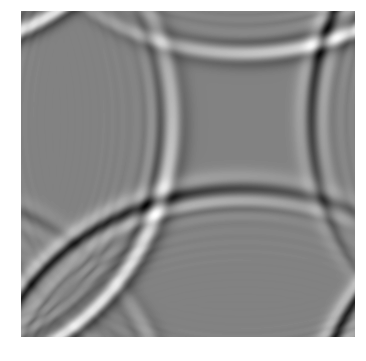

In [21]:
for t in np.linspace(0, .4, 10):
    pl.figure(figsize=(18, 6))
    pl.contourf(x, y, hillshade(interp_on_time(t), 45, 20), 200, cmap="gray")
    pl.grid(False)
    pl.axis('off')